In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("../data/btc.csv")

In [4]:
df = data[['date', 'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume']]

In [5]:
df = df.rename(columns={"adjClose": "Close", "adjHigh": "High", "adjLow": "Low", "adjOpen": "Open", "adjVolume": "Volume"})

In [6]:
df

,date,Close,High,Low,Open,Volume
0,2011-08-19,10.900000,10.900000,10.900000,10.900000,0.490000
1,2011-08-20,11.690000,11.850000,11.150000,11.850000,1.930000
2,2011-08-21,11.700000,11.700000,11.700000,11.700000,0.090000
3,2011-08-22,11.700000,11.700000,11.700000,11.700000,0.090000
4,2011-08-23,11.700000,11.700000,11.700000,11.700000,0.030000
...,...,...,...,...,...,...
3506,2021-04-27,55028.866549,55472.954585,53258.462557,54012.025547,79338.378488
3507,2021-04-28,54855.547864,56427.987427,53852.128453,55031.798514,76799.010607
3508,2021-04-29,53561.797700,55200.367653,52348.401979,54862.041546,80509.607615
3509,2021-04-30,57727.556064,57999.077907,53025.527820,53559.203115,87996.637244


In [7]:
from sklearn.preprocessing import MinMaxScaler


price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [17]:
print(x_train.shape)
print(0,'\n' ,x_train[0])
print(1,'\n' ,x_train[1])
print(2,'\n', x_train[2])

(2793, 19, 1)
0 
 [[-0.99972756]
 [-0.9997027 ]
 [-0.99970239]
 [-0.99970239]
 [-0.99970239]
 [-0.99974014]
 [-0.99975587]
 [-0.99981879]
 [-0.99981187]
 [-0.99979111]
 [-0.99979079]
 [-0.99981879]
 [-0.99980306]
 [-0.99983767]
 [-0.99988265]
 [-0.9998965 ]
 [-0.99990908]
 [-0.99991789]
 [-0.99991726]]
1 
 [[-0.9997027 ]
 [-0.99970239]
 [-0.99970239]
 [-0.99970239]
 [-0.99974014]
 [-0.99975587]
 [-0.99981879]
 [-0.99981187]
 [-0.99979111]
 [-0.99979079]
 [-0.99981879]
 [-0.99980306]
 [-0.99983767]
 [-0.99988265]
 [-0.9998965 ]
 [-0.99990908]
 [-0.99991789]
 [-0.99991726]
 [-0.99991569]]
2 
 [[-0.99970239]
 [-0.99970239]
 [-0.99970239]
 [-0.99974014]
 [-0.99975587]
 [-0.99981879]
 [-0.99981187]
 [-0.99979111]
 [-0.99979079]
 [-0.99981879]
 [-0.99980306]
 [-0.99983767]
 [-0.99988265]
 [-0.9998965 ]
 [-0.99990908]
 [-0.99991789]
 [-0.99991726]
 [-0.99991569]
 [-0.99991632]]


In [8]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    

In [12]:
model_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_lstm.parameters(), lr=0.01)

In [13]:
# import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model_lstm(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
#     print("Epoch ", t, "Mean Squared Error: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
# print("Training time: {}".format(training_time))

In [14]:
y_pred_lstm = model_lstm(x_test)


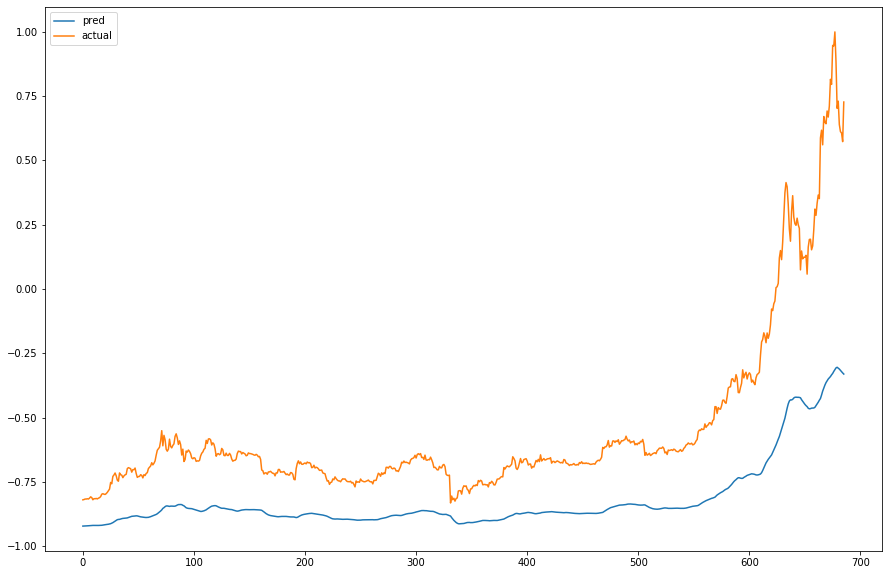

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_lstm.detach().numpy(), label ='pred')
plt.plot(y_test, label ='actual')
plt.title('LSTM Prediction')
plt.legend(loc='best')

In [16]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [17]:
model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_gru.parameters(), lr=0.01)

In [18]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model_gru(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
#     print("Epoch ", t, "Mean Squared Error: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time

In [19]:
y_pred_gru = model_gru(x_test)

In [20]:
df.describe()

,Close,High,Low,Open,Volume
count,3451.000000,3451.000000,3451.000000,3451.000000,3451.000000
mean,4053.633027,4190.566685,3877.587350,4042.403997,37430.348478
std,6717.142225,6952.430737,6379.282516,6675.223190,48383.365448
min,2.240000,2.270000,2.220000,2.220000,0.030000
25%,232.995000,239.999000,226.500000,233.152500,5128.155000
50%,648.760000,666.300000,626.000000,650.000000,17025.380000
75%,6905.303491,7221.551980,6637.814234,6909.033381,55481.299836
max,57424.034546,58356.674988,55426.265543,57428.869519,633959.939587


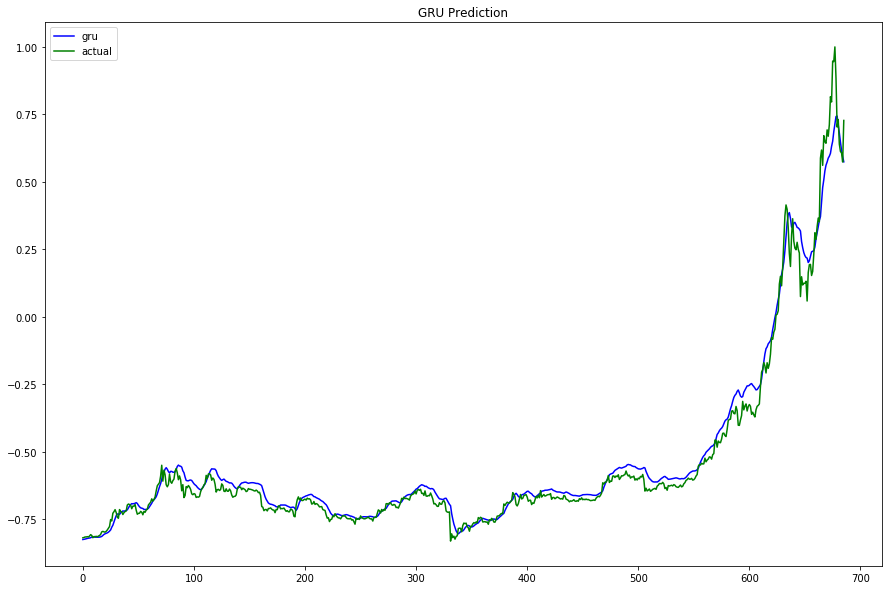

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_gru.detach().numpy(), label ='gru', color='blue')
plt.plot(y_test, label ='actual', color='green')
plt.title('GRU Prediction')
plt.legend(loc='best')

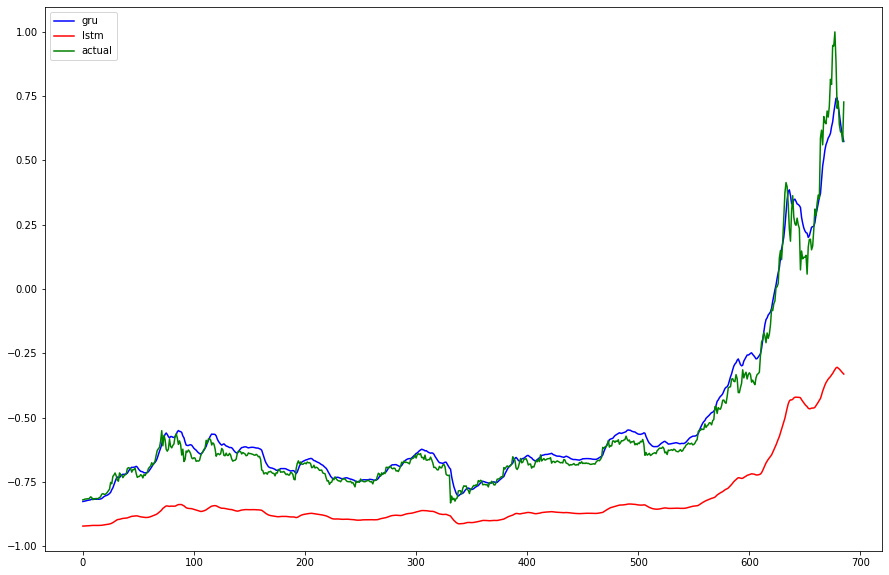

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_gru.detach().numpy(), label ='gru', color='blue')
plt.plot(y_pred_lstm.detach().numpy(), label ='lstm', color=  'red')

plt.plot(y_test, label ='actual', color='green')
plt.legend(loc='best')

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

# TF


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.GRU(units=75, return_sequences =True,input_shape=(x_train.shape[1], x_train.shape[2])))
model_gru.add(tf.keras.layers.GRU(units=30, return_sequences =True))
model_gru.add(tf.keras.layers.GRU(units=30, return_sequences =True))
model_gru.add(tf.keras.layers.GRU(units=30))
model_gru.add(tf.keras.layers.Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')
model_gru.summary()

history_gru = model_gru.fit(x_train, y_train, epochs =100, batch_size=64, validation_data =(x_test, y_test), shuffle=False)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 19, 75)            17550     
_________________________________________________________________
gru_17 (GRU)                 (None, 19, 30)            9630      
_________________________________________________________________
gru_18 (GRU)                 (None, 19, 30)            5580      
_________________________________________________________________
gru_19 (GRU)                 (None, 30)                5580      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 38,371
Trainable params: 38,371
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
44/44 [==============================] - 3s 59ms/step - loss: 0.2261 - val_loss: 0.1818
Epoch 2/100
44/4

44/44 [==============================] - 1s 31ms/step - loss: 0.0433 - val_loss: 0.0821
Epoch 73/100
44/44 [==============================] - 1s 32ms/step - loss: 0.0614 - val_loss: 0.1312: 0s 
Epoch 74/100
44/44 [==============================] - 1s 32ms/step - loss: 0.0480 - val_loss: 0.0903
Epoch 75/100
44/44 [==============================] - 1s 32ms/step - loss: 0.0559 - val_loss: 0.0914
Epoch 76/100
44/44 [==============================] - 1s 32ms/step - loss: 0.0479 - val_loss: 0.1195
Epoch 77/100
44/44 [==============================] - 1s 33ms/step - loss: 0.0394 - val_loss: 0.1476
Epoch 78/100
44/44 [==============================] - 1s 31ms/step - loss: 0.0383 - val_loss: 0.1231
Epoch 79/100
44/44 [==============================] - 1s 31ms/step - loss: 0.0437 - val_loss: 0.0995
Epoch 80/100
44/44 [==============================] - 1s 31ms/step - loss: 0.0363 - val_loss: 0.1457
Epoch 81/100
44/44 [==============================] - 1s 31ms/step - loss: 0.0471 - val_loss: 0.145

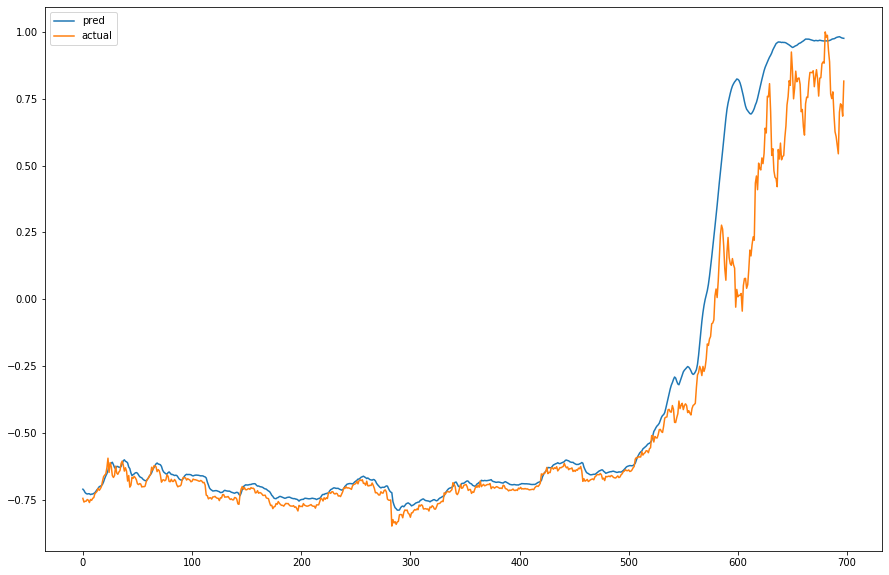

In [32]:
y_pred_tf_gru = model_gru.predict(x_test)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_tf_gru, label ='pred')
plt.plot(y_test, label ='actual')
plt.legend(loc='best')

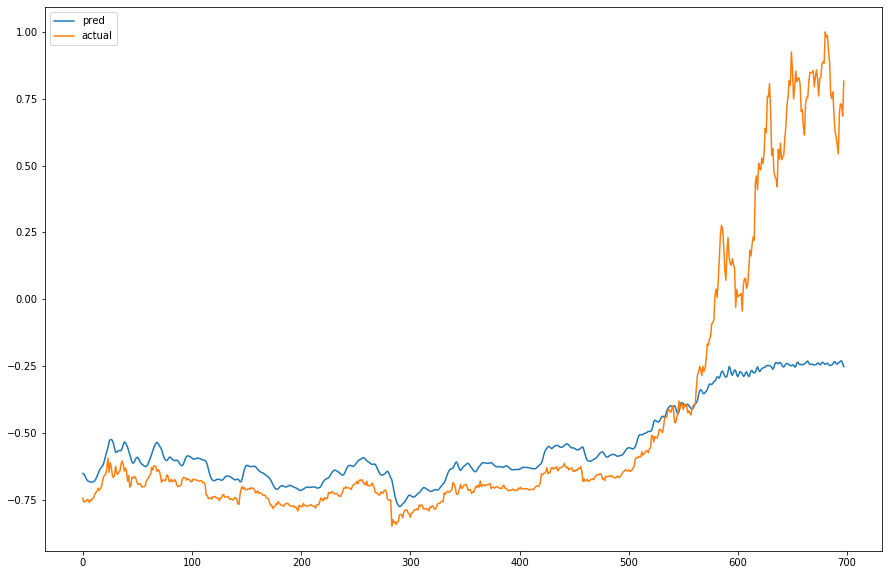

In [35]:
y_pred_tf_gru = model_gru.predict(x_test)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(y_pred_tf_gru, label ='pred')
plt.plot(y_test, label ='actual')
plt.legend(loc='best')